references:


*   Multivariate Time Series Forecasting with LSTMs in Keras (machinelearningmastery.com)
*   https://www.youtube.com/watch?v=4FmVIpcwl4k&t=1117s


*   BOOK: Hands-on time series analysis
*   List item





In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.compat.v1.set_random_seed(2)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

mpl.rcParams['figure.figsize'] = (20, 20)
mpl.rcParams['axes.grid'] = False

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [ ]:
df = pd.read_csv('/content/clean_monthly_df_human_supervised.csv')

In [ ]:
df.head()

,time,MIN_TEMPERATURE_C_t_1,max_clients_month_t_1,total_Holiday_Food_Related_t_1,total_consommation_t_1,max_pdl_total_daily_load_t_1,max_pdl_daily_load_t_1,MIN_TEMPERATURE_C_t,max_clients_month_t,total_Holiday_Food_Related_t,total_consommation_t,max_pdl_total_daily_load_t,max_pdl_daily_load_t
0,28/02/2015,8,3980,2,247497.63,22257,1479,11,4023,0,263249.88,22242,1494
1,31/03/2015,11,4023,0,263249.88,22242,1494,12,4060,0,246311.89,21691,1551
2,30/04/2015,12,4060,0,246311.89,21691,1551,14,4094,0,237177.99,16752,1253
3,31/05/2015,14,4094,0,237177.99,16752,1253,19,4112,0,229106.03,12318,1123
4,30/06/2015,19,4112,0,229106.03,12318,1123,22,4137,13,223934.14,11655,1122


In [ ]:
df.tail()

,time,MIN_TEMPERATURE_C_t_1,max_clients_month_t_1,total_Holiday_Food_Related_t_1,total_consommation_t_1,max_pdl_total_daily_load_t_1,max_pdl_daily_load_t_1,MIN_TEMPERATURE_C_t,max_clients_month_t,total_Holiday_Food_Related_t,total_consommation_t,max_pdl_total_daily_load_t,max_pdl_daily_load_t
61,31/03/2020,11,5348,0,222261.04,23365,1451,9,5321,0,219707.61,23370,1463
62,30/04/2020,9,5321,0,219707.61,23370,1463,12,5324,7,207015.41,18875,1599
63,31/05/2020,12,5324,7,207015.41,18875,1599,18,5326,26,193552.21,15439,1400
64,30/06/2020,18,5326,26,193552.21,15439,1400,20,5324,0,182548.79,14697,1105
65,31/07/2020,20,5324,0,182548.79,14697,1105,23,5277,1,177683.15,13664,1084


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            66 non-null     object 
 1   MIN_TEMPERATURE_C_t_1           66 non-null     int64  
 2   max_clients_month_t_1           66 non-null     int64  
 3   total_Holiday_Food_Related_t_1  66 non-null     int64  
 4   total_consommation_t_1          66 non-null     float64
 5   max_pdl_total_daily_load_t_1    66 non-null     int64  
 6   max_pdl_daily_load_t_1          66 non-null     int64  
 7   MIN_TEMPERATURE_C_t             66 non-null     int64  
 8   max_clients_month_t             66 non-null     int64  
 9   total_Holiday_Food_Related_t    66 non-null     int64  
 10  total_consommation_t            66 non-null     float64
 11  max_pdl_total_daily_load_t      66 non-null     int64  
 12  max_pdl_daily_load_t            66 non

In [ ]:
time = pd.to_datetime(df['time'], dayfirst=True).dropna()

In [ ]:
df.describe()

,MIN_TEMPERATURE_C_t_1,max_clients_month_t_1,total_Holiday_Food_Related_t_1,total_consommation_t_1,max_pdl_total_daily_load_t_1,max_pdl_daily_load_t_1,MIN_TEMPERATURE_C_t,max_clients_month_t,total_Holiday_Food_Related_t,total_consommation_t,max_pdl_total_daily_load_t,max_pdl_daily_load_t
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,16.833333,4768.469697,3.500000,228764.090152,16520.727273,1264.818182,17.060606,4788.121212,3.484848,227706.295000,16390.530303,1258.833333
std,5.682858,441.257442,7.190271,28276.748973,5479.954448,201.969983,5.623792,434.430822,7.194533,28864.887407,5443.529444,201.377150
min,8.000000,3980.000000,0.000000,141878.540000,7586.000000,892.000000,8.000000,4023.000000,0.000000,141878.540000,7586.000000,892.000000
25%,12.000000,4363.250000,0.000000,213317.625000,11801.000000,1099.000000,12.000000,4391.500000,0.000000,212747.710000,11801.000000,1096.250000
50%,16.000000,4788.000000,0.500000,228354.610000,15427.000000,1273.500000,16.000000,4819.000000,0.500000,228211.575000,15143.000000,1270.000000
75%,22.000000,5199.250000,2.000000,247201.195000,21182.250000,1440.000000,22.000000,5214.500000,2.000000,245909.882500,20605.000000,1417.000000
max,27.000000,5354.000000,28.000000,313725.300000,27936.000000,1628.000000,27.000000,5354.000000,28.000000,313725.300000,27936.000000,1628.000000


In [ ]:
df.columns

Index(['time', 'MIN_TEMPERATURE_C_t_1', 'max_clients_month_t_1',
       'total_Holiday_Food_Related_t_1', 'total_consommation_t_1',
       'max_pdl_total_daily_load_t_1', 'max_pdl_daily_load_t_1',
       'MIN_TEMPERATURE_C_t', 'max_clients_month_t',
       'total_Holiday_Food_Related_t', 'total_consommation_t',
       'max_pdl_total_daily_load_t', 'max_pdl_daily_load_t'],
      dtype='object')

In [ ]:
df_input=df[['MIN_TEMPERATURE_C_t_1', 'max_clients_month_t_1',
       'total_Holiday_Food_Related_t_1', 'total_consommation_t_1',
       'max_pdl_total_daily_load_t_1', 'max_pdl_daily_load_t_1',
       
       'MIN_TEMPERATURE_C_t', 'max_clients_month_t',
       'total_Holiday_Food_Related_t','max_pdl_daily_load_t']].dropna()

the add of weekend feature makes the seasonal weekend decrease more visible, so increases performance

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled[-1]

array([0.63157895, 0.97816594, 0.        , 0.23666579, 0.34943489,
       0.28940217, 0.78947368, 0.94214876, 0.03571429, 0.26086957])

In [ ]:
features=data_scaled[:,:-1]
target=data_scaled[:,-1]

In [ ]:
features.shape

(66, 9)

In [ ]:
target.shape

(66,)

In [ ]:
# split into train and test sets

n_train_days = -7 #train months 

train_X,train_y = features[:n_train_days, :],target[:n_train_days]
test_X, test_y = features[n_train_days:, :],target[n_train_days:]

# reshape input to be 3D
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(59, 9, 1) (59,) (7, 9, 1) (7,)


In [ ]:
def create_model(layers):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(LSTM(units=nodes,input_shape= (train_X.shape[1],1), kernel_constraint=maxnorm(3.5)))
            model.add(Dropout(0.3))
        else:
            model.add(LSTM(units=nodes, kernel_constraint=maxnorm(3.5)))
            model.add(Dropout(0.3))
    model.add(Dense(1)) 
    
    model.compile(loss='mse', optimizer='adam')
    return model

model = KerasClassifier(build_fn=create_model, verbose=0) #build_fn is the name of the 
#function to call to get your model.   
tscv = TimeSeriesSplit(n_splits=4)
layers = [[100], [100, 50], [100,50, 25]]
batches=[4,8]
epochs=[100,200]
param_grid = dict(layers=layers, batch_size = batches , epochs=epochs)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_grid,scoring='r2')
grid_result=gsearch.fit(train_X, train_y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

Best: -3.337210 using {'batch_size': 4, 'epochs': 100, 'layers': [100]}


In [ ]:
model = Sequential()
model.add(LSTM(units=100,input_shape= (train_X.shape[1],1),kernel_constraint=maxnorm(3.5)))
model.add(Dropout(0.3))
model.add(Dense(units=1))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='min',verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, 
                     save_best_only=True)
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=100, batch_size=4,validation_data=(test_X,test_y),
                    verbose=0,callbacks=[es,mc], shuffle=False)


Epoch 00001: val_loss improved from inf to 0.22276, saving model to best_model.h5

Epoch 00002: val_loss did not improve from 0.22276

Epoch 00003: val_loss did not improve from 0.22276

Epoch 00004: val_loss did not improve from 0.22276

Epoch 00005: val_loss did not improve from 0.22276

Epoch 00006: val_loss did not improve from 0.22276

Epoch 00007: val_loss improved from 0.22276 to 0.21700, saving model to best_model.h5

Epoch 00008: val_loss improved from 0.21700 to 0.21467, saving model to best_model.h5

Epoch 00009: val_loss improved from 0.21467 to 0.18621, saving model to best_model.h5

Epoch 00010: val_loss improved from 0.18621 to 0.17193, saving model to best_model.h5

Epoch 00011: val_loss improved from 0.17193 to 0.13561, saving model to best_model.h5

Epoch 00012: val_loss improved from 0.13561 to 0.13061, saving model to best_model.h5

Epoch 00013: val_loss did not improve from 0.13061

Epoch 00014: val_loss did not improve from 0.13061

Epoch 00015: val_loss did not 

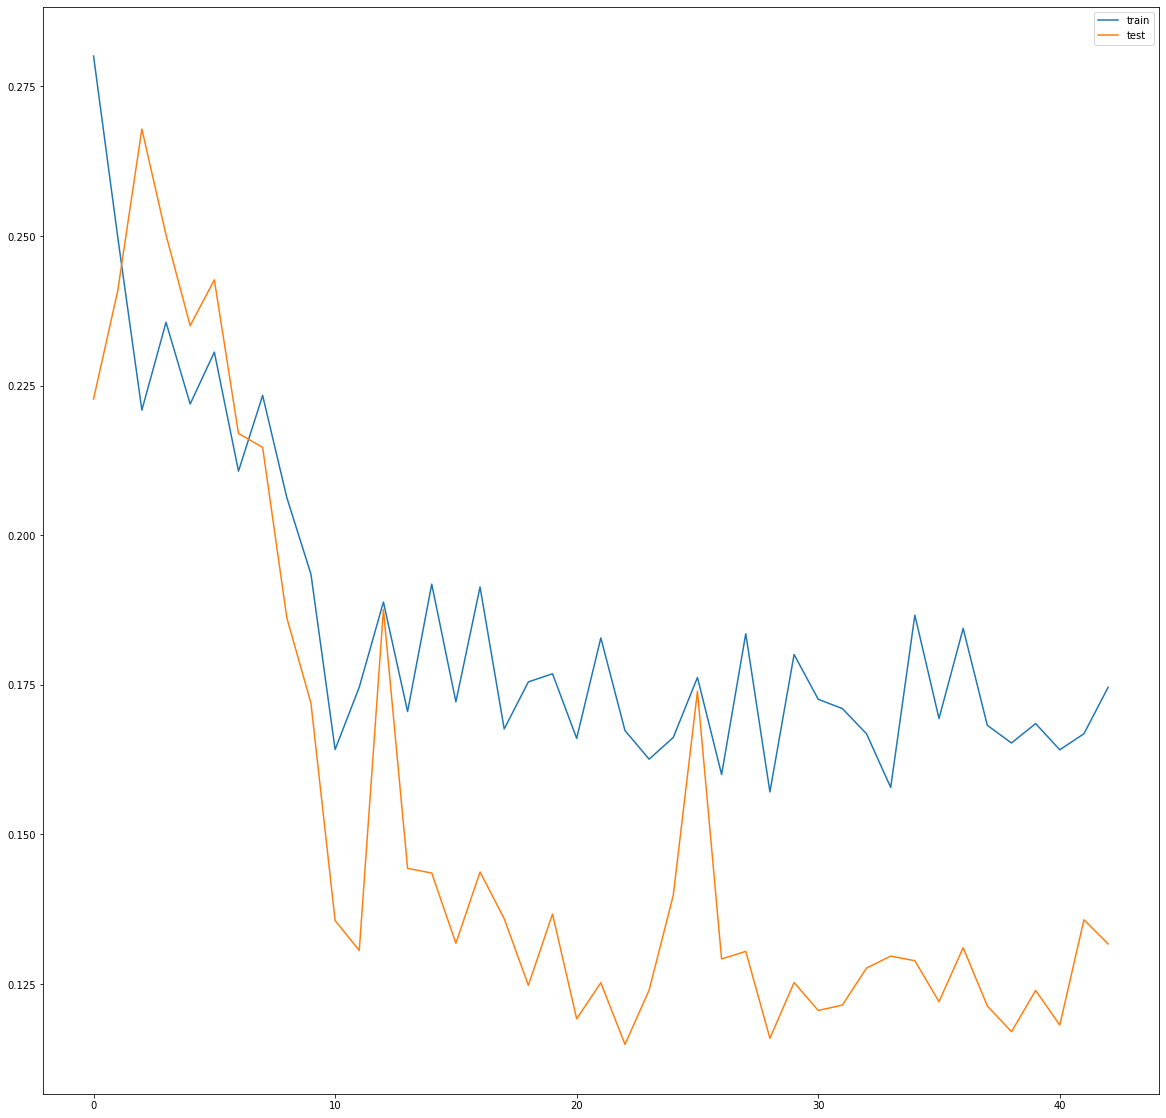

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
  # load the saved model
model = load_model('best_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# make a prediction
yhat = model.predict(test_X) #shape=(14,1)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
#inv_yhat = concatenate((test_X[:, :-1],yhat), axis=1)
inv_yhat = concatenate((test_X,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_X[:, :-1],test_y), axis=1)
inv_y = concatenate((test_X,test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  def smape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 2/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum((np.abs(y_true)+np.abs(y_pred)))*100
  def mase(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_pred=y_true[1:]
    return 1/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true[:len(y_true)-1]-naive_pred))*(y_true.shape[0]-1)
  #def owe(y_true,y_pred):
   # return (mase(y_true,y_pred)+smape(y_true,y_pred))/2

  print('Evaluation metric results:-')
  print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
  print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
  #mape.append(mean_absolute_percentage_error(y_true, y_pred))
  #rmse.append(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
  print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
  print('SMAPE is : '+str(smape(y_true,y_pred))+'\n')
  print('MASE is : '+str(mase(y_true,y_pred)))
  return

In [ ]:
from sklearn import metrics
import numpy as np

timeseries_evaluation_metrics_func(inv_y, inv_yhat)

Evaluation metric results:-
MSE is : 10655.916648791006
MAE is : 84.57849230085101
RMSE is : 103.22749947950403
MAPE is : 6.17754213551925 %
R2 is : 0.7085492119592529

SMAPE is : 0.8798685666175332

MASE is : 0.6573457950843341


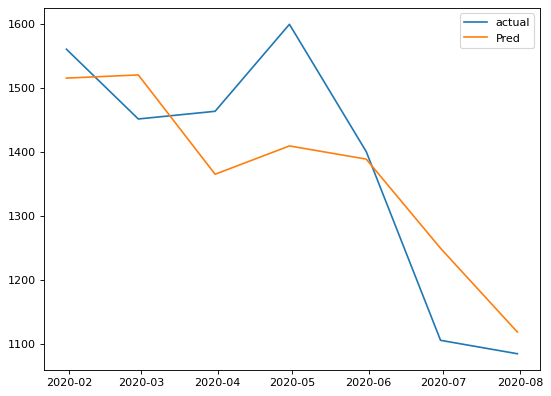

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(time[train_X.shape[0]:len(time)],inv_y,label='actual')
plt.plot(time[train_X.shape[0]:len(time)],inv_yhat,label='Pred')
plt.legend()
#plt.savefig('xgboost_test')
plt.show()

# peak period

In [ ]:
timeseries_evaluation_metrics_func(inv_y[:3], inv_yhat[:3])

Evaluation metric results:-
MSE is : 5486.1595182088895
MAE is : 70.78961753845215
RMSE is : 74.06861358368259
MAPE is : 4.787724573035385 %
R2 is : -1.3036034181151441

SMAPE is : 1.5955547026389183

MASE is : 1.1700763229496223


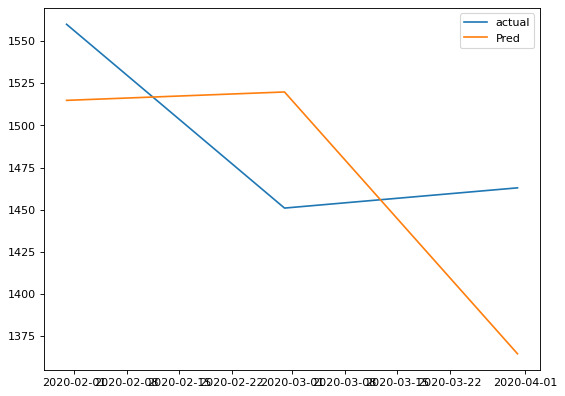

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(time[train_X.shape[0]:train_X.shape[0]+3],inv_y[:3],label='actual')
plt.plot(time[train_X.shape[0]:train_X.shape[0]+3],inv_yhat[:3],label='Pred')
plt.legend()
plt.show()